In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
titanic_data = pd.read_csv("datasets/titanic_data/train.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
unwanted_features = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Embarked']

In [4]:
titanic_data = titanic_data.drop(unwanted_features, axis=1)
titanic_data

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500
...,...,...,...,...,...
886,0,2,male,27.0,13.0000
887,1,1,female,19.0,30.0000
888,0,3,female,NaN,23.4500
889,1,1,male,26.0,30.0000


In [5]:
titanic_data = titanic_data.dropna()

In [6]:
le = preprocessing.LabelEncoder()

In [7]:
titanic_data['Sex'] = le.fit_transform(titanic_data['Sex'])
titanic_data.head()

C:\Users\natha\AppData\Local\Temp\ipykernel_18376\3543859060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_data['Sex'] = le.fit_transform(titanic_data['Sex'])


,Survived,Pclass,Sex,Age,Fare
0,0,3,1,22.0,7.2500
1,1,1,0,38.0,71.2833
2,1,3,0,26.0,7.9250
3,1,1,0,35.0,53.1000
4,0,3,1,35.0,8.0500


In [8]:
features = ['Pclass', 'Sex', 'Age', 'Fare']

In [9]:
titanic_features = titanic_data[features]
titanic_features.head()

,Pclass,Sex,Age,Fare
0,3,1,22.0,7.2500
1,1,0,38.0,71.2833
2,3,0,26.0,7.9250
3,1,0,35.0,53.1000
4,3,1,35.0,8.0500


In [10]:
titanic_features = pd.get_dummies(titanic_features, columns = ['Pclass'])
titanic_features.head()

,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,7.2500,0,0,1
1,0,38.0,71.2833,1,0,0
2,0,26.0,7.9250,0,0,1
3,0,35.0,53.1000,1,0,0
4,1,35.0,8.0500,0,0,1


In [11]:
titanic_target = titanic_data[['Survived']]
titanic_target.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [12]:
X_train, x_test, Y_train, y_test = train_test_split(titanic_features, titanic_target, test_size=0.2, random_state=0)

In [13]:
X_train.shape, Y_train.shape

((571, 6), (571, 1))

In [14]:
Xtrain_ = torch.from_numpy(X_train.values).float()
Xtest_ = torch.from_numpy(x_test.values).float()

In [15]:
Xtrain_.shape

torch.Size([571, 6])

In [16]:
Ytrain_ = torch.from_numpy(Y_train.values).view(1, -1)[0]
Ytest_ = torch.from_numpy(y_test.values).view(1, -1)[0]

In [17]:
Ytrain_.shape 

torch.Size([571])

In [18]:
input_size = 6
output_size = 2
hidden_size = 10

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim =-1)

In [20]:
model = Net()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()

In [21]:
epoch_data = [ ]
epochs = 1001

In [22]:
for epoch in range(1, epochs):
    optimizer.zero_grad()
    Ypred = model(Xtrain_)
    loss = loss_fn(Ypred, Ytrain_)
    loss.backward()
    optimizer.step()
    Ypred_test = model(Xtest_)
    loss_test = loss_fn(Ypred_test, Ytest_)
    _, pred = Ypred_test.data.max(1)
    accuracy = pred.eq(Ytest_.data).sum().item() / y_test.values.size
    epoch_data.append([epoch, loss.data.item(), loss_test.data.item(), accuracy])

    if epoch % 100 == 0:
        print ('epoch - %d (%d%%) train loss - %.2f test loss - %.2f accuracy - %.4f' % (epoch, epoch/150 * 10, loss.data.item(), loss_test.data.item(), accuracy))

C:\Users\natha\AppData\Roaming\Python\Python310\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch - 100 (6%) train loss - 0.65 test loss - 0.66 accuracy - 0.5524
epoch - 200 (13%) train loss - 0.61 test loss - 0.62 accuracy - 0.6783
epoch - 300 (20%) train loss - 0.59 test loss - 0.59 accuracy - 0.6853
epoch - 400 (26%) train loss - 0.56 test loss - 0.56 accuracy - 0.7063
epoch - 500 (33%) train loss - 0.51 test loss - 0.50 accuracy - 0.7832
epoch - 600 (40%) train loss - 0.46 test loss - 0.44 accuracy - 0.8322
epoch - 700 (46%) train loss - 0.43 test loss - 0.41 accuracy - 0.8112
epoch - 800 (53%) train loss - 0.42 test loss - 0.40 accuracy - 0.8182
epoch - 900 (60%) train loss - 0.41 test loss - 0.40 accuracy - 0.8182
epoch - 1000 (66%) train loss - 0.40 test loss - 0.40 accuracy - 0.8182


In [23]:
df_epochs_data = pd.DataFrame(epoch_data, columns = ['epoch', 'train_loss', 'test_loss', 'accuracy'])

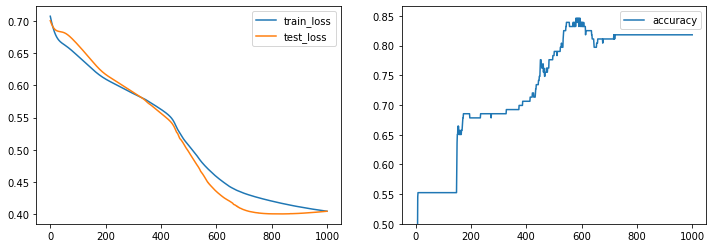

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df_epochs_data[['train_loss', 'test_loss']].plot(ax=ax1)
df_epochs_data[['accuracy']].plot(ax=ax2)
plt.ylim(ymin=0.5)
plt.show()